# Beer Type Prediction

## Initialise Data and Environment

default in local docker container

training in AWS g3.4xlarge

In [1]:
import numpy as np
import pandas as pd
import os

# set parent folder for this notebook folder as working directory
os.chdir(os.getcwd().rsplit('/',1)[0])

#### Load and transform data: 
brewery_name is dropped for now, because: 

- there are over 5,000 brewery names
    - hypothesis is that brewery_name is not going to help with model performance (this hypothesis is not tested with experiment in this report, but is suggested for future exercise)


- brewery_name may also cause typo problem in API, this will also increase complexity with API design

only 4 numeric features remains for modelling:

    review_aroma, review_appearance, review_palate, review_taste

In [2]:
# set loadstatus to false by default
loadstatus = False
traindata_path = 'data/processed/'

# check if training data is already stored, 
# if exist: load data and and set loadstatus to true

if os.path.exists(f'{traindata_path}X_train.npy'):
    X_train = np.load(f'{traindata_path}X_train.npy')
    X_val = np.load(f'{traindata_path}X_val.npy')
    X_test = np.load(f'{traindata_path}X_test.npy')
    y_train = np.load(f'{traindata_path}y_train.npy')
    y_val = np.load(f'{traindata_path}y_val.npy')
    y_test = np.load(f'{traindata_path}y_test.npy')
    
    loadstatus = True

In [3]:
loadstatus

True

In [4]:
from src.data.load_dataset import load_data

if loadstatus == False:
    raw_filepath = 'data/raw/beer_reviews.csv'
    cleaned_filepath = 'data/processed/beer_review_cleaned.csv'

    # load and cleanse data
    df_cleaned=load_data(raw_filepath, cleaned_filepath)
    
    # extract target label column
    target = df_cleaned.pop('beer_style')

In [5]:
# scale data with standard scaler, save the fitted scaler to folder
from src.data.load_dataset import scale_features
from sklearn.preprocessing import StandardScaler

if loadstatus == False:
    sc = StandardScaler()
    df_scaled = scale_features(df_cleaned, sc)

In [6]:
# encode target with label encoder
from src.data.load_dataset import encode_label
from sklearn.preprocessing import LabelEncoder

if loadstatus == False:
    enc = LabelEncoder()
    enc_target = encode_label(target, enc)

In [7]:
from src.models.train_model import split_data

if loadstatus == False:
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_scaled, enc_target)

### Convert data into tensor

In [8]:
from src.models.pytorch import PytorchDataset

train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

## Hyperparameter Tuning

- learning rate
- number of neurons in hidden layer
- add model layers

#### Define Training Function for Hyperparameter Tuning

In [9]:
from src.models.pytorch import PytorchMCxlayers
from src.models.pytorch import train_classification, test_classification
from src.models.pytorch import get_device
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time

def train_model(lr=0.01, neus=256, epochs=3, batch_size=16):
    from src.models.train_model import model_test_case

    device = get_device()
    
    print(f'=========== learning rate: {lr}, hidden layer neurons: {neus} ============')
    model = PytorchMCxlayers(num_features=X_train.shape[1], hlayer_neurons=neus, device=device)
    
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    N_EPOCHS = epochs
    BATCH_SIZE = batch_size

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    for epoch in range(N_EPOCHS):
        tic = time.perf_counter()
#         start = torch.cuda.Event(enable_timing=True)
#         end = torch.cuda.Event(enable_timing=True)

#         start.record()

        train_loss, train_acc = train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
        valid_loss, valid_acc = test_classification(val_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)

        print(f'Epoch: {epoch}')
        print(f'\t(train)\t|\tLoss: {train_loss:.4f}\t|\tAcc: {train_acc * 100:.1f}%')
        print(f'\t(valid)\t|\tLoss: {valid_loss:.4f}\t|\tAcc: {valid_acc * 100:.1f}%')

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        
        toc = time.perf_counter()
        print(f"Epoch took {toc - tic:0.4f} seconds")

#         end.record()

        # Waits for everything to finish running
#         torch.cuda.synchronize()

        # convert milisecond into minutes
#         timecost = round(start.elapsed_time(end)/1000/60, 2)
#         print(f'Time taken for this epoch = {timecost} minutes. \n')
        
    epoch_count = range(1, len(train_accs)+1)

    plt.plot(epoch_count, train_accs, 'r--')
    plt.plot(epoch_count, valid_accs, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    plt.show()
    
    model_test_case(model=model, aroma=33, appearance=18, palate=46, taste=41, device=device)
    
    return model

#### Tune Learning Rate

=========== learning rate: 1e-06, hidden layer neurons: 256 ============
Epoch: 0
	(train)	|	Loss: 0.3464	|	Acc: 5.5%
	(valid)	|	Loss: 0.3462	|	Acc: 7.7%
Epoch took 198.4132 seconds
Epoch: 1
	(train)	|	Loss: 0.3454	|	Acc: 7.5%
	(valid)	|	Loss: 0.3453	|	Acc: 8.8%
Epoch took 254.0136 seconds


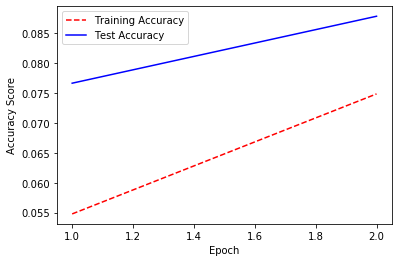

['American Double / Imperial IPA']


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
from src.models.pytorch import train_classification, test_classification

rate = 1e-6
neus = 256
epochs = 4

model = train_model(lr=rate, neus=neus, epochs=epochs)